In [65]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
pip install --upgrade torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Natural language processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer

# Machine learning and deep learning
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
#from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torchtext.vocab import Vectors
from sklearn.neural_network import MLPClassifier
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import logging
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_val_score, GridSearchCV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Other
import random
from collections import defaultdict
import time
import datetime
import warnings



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
#google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
pwd

'/content'

In [ ]:
from google.colab import files
uploaded = files.upload()

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Define column names
COLUMNS = ("Headline", "articleBody", "Stance")
HEADLINE_COLUMN, BODY_COLUMN, STANCE_COLUMN = COLUMNS

# Define stance categories
CATEGORIES = {"agree": 0, "disagree": 1, "discuss": 2, "unrelated": 3}

# Load data
bodies_csv = pd.read_csv("/content/drive/My Drive/train_bodies.csv")
stances_csv = pd.read_csv("/content/drive/My Drive/train_stances.csv")

# Merge data
dataset = stances_csv.merge(bodies_csv, on='Body ID', how="inner")

# Convert stance categories to numeric values
dataset["Stance"] = dataset["Stance"].apply(lambda x: CATEGORIES[x])

# Split data into train, validation and test sets
train, temp = train_test_split(dataset, test_size=0.2, random_state=1)
val, test = train_test_split(temp, test_size=0.5, random_state=1)

# Get headlines, bodies, and stance values for train, validation and test sets
train_headlines = train[HEADLINE_COLUMN].values
train_bodies = train[BODY_COLUMN].values
train_truth = np.array(train[STANCE_COLUMN].values)
train_related_truth = np.array([int(stance < 3) for stance in train_truth])

print("Number of training examples before balancing: ", len(train))
print("Number of validation examples before balancing: ", len(val))
print("Number of test examplesbefore balancing: ", len(test))

# Balancing training examples for related and unrelated classes
balanced_indices = []
for label in [0, 1]:
    indices = np.where(train_related_truth == label)[0]
    num_examples = min(len(indices), 13427)  # set max number of examples to 13427 for balancing
    balanced_indices += list(np.random.choice(indices, num_examples, replace=False))
np.random.shuffle(balanced_indices)

train_headlines = train_headlines[balanced_indices]
train_bodies = train_bodies[balanced_indices]
train_truth = train_truth[balanced_indices]
train_related_truth = train_related_truth[balanced_indices]

val_headlines = val[HEADLINE_COLUMN].values
val_bodies = val[BODY_COLUMN].values
val_truth = np.array(val[STANCE_COLUMN].values)
val_related_truth = np.array([int(stance < 3) for stance in val_truth])

test_headlines = test[HEADLINE_COLUMN].values
test_bodies = test[BODY_COLUMN].values
test_truth = np.array(test[STANCE_COLUMN].values)
test_related_truth = np.array([int(stance < 3) for stance in test_truth])

print("\n \n Number of training examples after Balancing: ", len(train_headlines))
print("Number of validation examples after balancing: ", len(val_headlines))
print("Number of test examples after balancing: ", len(test_headlines))

Number of training examples before balancing:  39977
Number of validation examples before balancing:  4997
Number of test examplesbefore balancing:  4998

 
 Number of training examples after Balancing:  24162
Number of validation examples after balancing:  4997
Number of test examples after balancing:  4998


In [6]:
# Count number of examples for each stance
stance_counts = dataset.groupby("Stance").size().reset_index(name="Count")

# Print number of examples for each stance
print(stance_counts)

   Stance  Count
0       0   3678
1       1    840
2       2   8909
3       3  36545


In [ ]:
DATA CLEAN UP

In [63]:
pip install --upgrade nltk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [72]:
# Import the necessary libraries
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a set of stopwords
stop = set(stopwords.words('english'))

# Function to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

# Function to remove HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

# Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Function to clean the data
def data_cleanup(data):
    # Remove URLs, HTML tags, and emojis
    x = list(map(remove_URL, data))
    x = list(map(remove_html, x))
    x = list(map(remove_emoji, x))
    
    # Apply lemmatization to each word in the text
    x = [' '.join([lemmatizer.lemmatize(word) for word in text.split()]) for text in x]
    
    # Convert the cleaned data to a numpy array
    x = np.array(x)
    
    return x

# Function to remove stopwords from a string
def remove_stop_words(string):
    # Split the string into words
    split_words = string.split()
    
    # Remove stopwords and return the remaining words as a string
    return " ".join([word for word in split_words if word.lower() not in stop])

# Remove stopwords from the training and testing data
for index, (headline, body) in enumerate(zip(train_headlines, train_bodies)):
    train_headlines[index] = remove_stop_words(headline)
    train_bodies[index] = remove_stop_words(body)

for index, (headline, body) in enumerate(zip(val_headlines, val_bodies)):
    train_headlines[index] = remove_stop_words(headline)
    train_bodies[index] = remove_stop_words(body)

for index, (test_headline, test_body) in enumerate(zip(test_headlines, test_bodies)):
    test_headlines[index] = remove_stop_words(test_headline)
    test_bodies[index] = remove_stop_words(test_body)

# Clean the training and testing data
train_headlines = data_cleanup(train_headlines)
train_bodies = data_cleanup(train_bodies)
val_headlines = data_cleanup(val_headlines)
val_bodies = data_cleanup(val_bodies)
test_headlines = data_cleanup(test_headlines)
test_bodies = data_cleanup(test_bodies)


In [73]:
# Print examples of train headlines and train bodies
print("Examples of Train Headlines:")
for headline in train_headlines[:5]:
    print(headline)
    
print("\nExamples of Train Bodies:")
for body in train_bodies[:5]:
    print(body)


Examples of Train Headlines:
Kim Jong-un ‘is fat eating cheese broken ankles’
bendgate hairgate: iPhone 6 user complain device ripping hair
#Hairgate: iPhone 6 user say device pull hair
US confirms death Somalia terror group leader
Weather Reporter Caught Writing Name Snow Ready Go Camera (UPDATED)

Examples of Train Bodies:
unconfirmed report jihadist fighting Islamic State contracted Ebola. Local medium outlet reported case Ebola showed hospital IS-controlled city Mosul, Iraq, Mashable reported. Iraq’s official pro-government newspaper, al Sabaah, claimed disease arrived Mosul jihadist “from several countries” including Africa. official told Kurdish medium outlet Xendan militants’ symptom similar Ebola virus. Although symptom Ebola, include nausea, vomiting diarrhoea, easily mistaken many illness malaria. World Health Organisation (WHO) unable confirm cases. Christy Feig, WHO’s director communication told Mashable process reaching government official Iraq see help needed investigatin

In [74]:
# tf-idf feature extraction
tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2, stop_words='english', max_features=10000)
tfidf.fit(np.concatenate((train_headlines, train_bodies, test_headlines, test_bodies)))#.astype('U'))
tfidf_bodies = tfidf.transform(train_bodies)#.astype('U'))
tfidf_headlines = tfidf.transform(train_headlines)#.astype('U'))
tfidf_test_bodies = tfidf.transform(test_bodies)#.astype('U'))
tfidf_test_headlines = tfidf.transform(test_headlines)#.astype('U'))


In [ ]:
print(np.shape(tfidf_bodies))
print(np.shape(tfidf_headlines))
print(np.shape(tfidf.transform([train_bodies[0]])))

(24162, 10000)
(24162, 10000)
(1, 10000)


In [ ]:
# unrelated = 0, related = 1

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from time import time
from sklearn.metrics.pairwise import cosine_similarity


tfidf_similarity_vectors = []
for headline, body in zip(tfidf_headlines, tfidf_bodies):
    tfidf_similarity_vectors.append(cosine_similarity(headline, body)[0])
tfidf_similarity_vectors = np.array(tfidf_similarity_vectors)

# Train a Random Forest classifier on the similarity vectors
start = time()
model = RandomForestClassifier().fit(tfidf_similarity_vectors, train_related_truth)
print("Time taken to train the model: {:.2f} seconds".format(time() - start))

# Predict on the train set
train_predictions = model.predict(tfidf_similarity_vectors)
print("Train Data Metrics")
print(classification_report(train_related_truth, train_predictions))


# Predict on the test set
tfidf_similarity_vectors = []
for headline, body in zip(tfidf_test_headlines, tfidf_test_bodies):
    tfidf_similarity_vectors.append(cosine_similarity(headline, body)[0])
tfidf_similarity_vectors = np.array(tfidf_similarity_vectors)

test_predictions = model.predict(tfidf_similarity_vectors)
print("Test Data Metrics ")
print(classification_report(test_related_truth, test_predictions))



Time taken to train the model: 3.19 seconds
Train Data Metrics
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     13427
           1       1.00      0.89      0.94     10735

    accuracy                           0.95     24162
   macro avg       0.96      0.94      0.95     24162
weighted avg       0.95      0.95      0.95     24162

Test Data Metrics 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3647
           1       0.85      0.88      0.86      1351

    accuracy                           0.93      4998
   macro avg       0.90      0.91      0.91      4998
weighted avg       0.93      0.93      0.93      4998



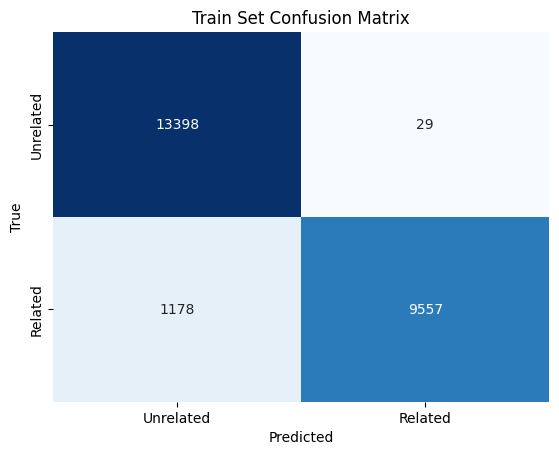

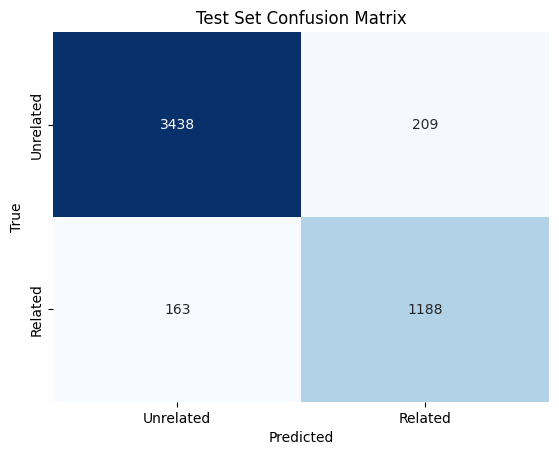

In [ ]:
import seaborn as sns

# Create a confusion matrix for the train set
train_cm = confusion_matrix(train_related_truth, train_predictions)

# Create a heatmap of the confusion matrix using seaborn
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', cbar=False, 
            xticklabels=['Unrelated', 'Related'], yticklabels=['Unrelated', 'Related'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Train Set Confusion Matrix')
plt.show()

# Create a confusion matrix for the test set
test_cm = confusion_matrix(test_related_truth, test_predictions)

# Create a heatmap of the confusion matrix using seaborn
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', cbar=False, 
            xticklabels=['Unrelated', 'Related'], yticklabels=['Unrelated', 'Related'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()


# BERT and SBERT

In [75]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=cf1c1f6e590fc955c981bd48db5c8a7d2329ce814dfd94c6b9bd7046a079976f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [76]:

from sentence_transformers import SentenceTransformer

# Load pre-trained sentence transformer model
sbert_encoder = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Encode training data using SBERT model
sbert_bodies = sbert_encoder.encode(train_bodies, show_progress_bar=True)
sbert_headlines = sbert_encoder.encode(train_headlines, show_progress_bar=True)

# Encode val data using SBERT model
sbert_val_bodies = sbert_encoder.encode(val_bodies, show_progress_bar=True)
sbert_val_headlines = sbert_encoder.encode(val_headlines, show_progress_bar=True)

# Encode Test data using SBERT model
sbert_test_bodies = sbert_encoder.encode(test_bodies, show_progress_bar=True)
sbert_test_headlines = sbert_encoder.encode(test_headlines, show_progress_bar=True)


Batches:   0%|          | 0/756 [00:00<?, ?it/s]

Batches:   0%|          | 0/756 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
# Print example outputs
print("Example output of SBERT bodies:")
print((sbert_bodies[0:5]))  

print("\nExample output of SBERT headlines:")
print(np.round(sbert_headlines[0:5]))  


Example output of SBERT bodies:
[[-0.06870851  0.13203943 -0.4862898  ... -0.51829493  0.37510782
   0.1184921 ]
 [-0.33986107  0.10990492  0.10817811 ... -0.38665244 -0.09878054
   0.46691132]
 [ 0.06687385  0.08916806 -0.43441382 ... -0.2329889  -0.42007324
   0.10020456]
 [-0.06815937  0.2567739  -0.38861668 ... -0.06276038  0.13752405
   0.02486517]
 [-0.2728786  -0.27448472  0.01792893 ... -0.04187806 -0.17776665
   0.22226666]]

Example output of SBERT headlines:
[[-0.  0.  0. ... -0.  0. -0.]
 [-0. -0.  1. ... -0.  0.  0.]
 [-0. -0.  0. ... -0.  0.  0.]
 [-0.  0. -0. ... -0.  0. -0.]
 [-1.  0. -1. ... -0. -1.  0.]]


In [ ]:
print(np.shape(sbert_bodies))
print(np.shape(sbert_headlines))

print(np.shape(sbert_val_bodies))
print(np.shape(sbert_val_headlines))

print(np.shape(sbert_test_bodies))
print(np.shape(sbert_test_headlines))

(24162, 384)
(24162, 384)
(4997, 384)
(4997, 384)
(4998, 384)
(4998, 384)


In [ ]:
# unrelated = 0, related = 1
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sentence_transformers import util


sbert_similarity_vectors = []
for headline, body in zip(sbert_headlines, sbert_bodies):
    sbert_similarity_vectors.append(util.pytorch_cos_sim(headline, body))
sbert_similarity_vectors = np.array(sbert_similarity_vectors)

sbert_model = RandomForestClassifier().fit(sbert_similarity_vectors.reshape(-1,1), train_related_truth)

train_predictions = sbert_model.predict(sbert_similarity_vectors.reshape(-1,1))
print("Train Data Metrics ")
print(classification_report(train_related_truth, train_predictions))
print("\n")

# test set
sbert_similarity_vectors = []
for headline, body in zip(sbert_test_headlines, sbert_test_bodies):
    sbert_similarity_vectors.append(util.pytorch_cos_sim(headline, body))
sbert_similarity_vectors = np.array(sbert_similarity_vectors)

test_predictions = sbert_model.predict(sbert_similarity_vectors.reshape(-1,1))
print(" Test Data Metrics ")
print(classification_report(test_related_truth, test_predictions))



<ipython-input-35-00c491272b2a>:10: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sbert_similarity_vectors = np.array(sbert_similarity_vectors)
<ipython-input-35-00c491272b2a>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sbert_similarity_vectors = np.array(sbert_similarity_vectors)


Train Data Metrics 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13427
           1       1.00      1.00      1.00     10735

    accuracy                           1.00     24162
   macro avg       1.00      1.00      1.00     24162
weighted avg       1.00      1.00      1.00     24162



 Test Data Metrics 
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      3647
           1       0.69      0.88      0.77      1351

    accuracy                           0.86      4998
   macro avg       0.82      0.86      0.83      4998
weighted avg       0.88      0.86      0.86      4998



<ipython-input-35-00c491272b2a>:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sbert_similarity_vectors = np.array(sbert_similarity_vectors)
<ipython-input-35-00c491272b2a>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sbert_similarity_vectors = np.array(sbert_similarity_vectors)


<ipython-input-40-6e6324d7828e>:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sbert_similarity_vectors = np.array(sbert_similarity_vectors)
<ipython-input-40-6e6324d7828e>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sbert_similarity_vectors = np.array(sbert_similarity_vectors)


Train Data Metrics 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13427
           1       1.00      1.00      1.00     10735

    accuracy                           1.00     24162
   macro avg       1.00      1.00      1.00     24162
weighted avg       1.00      1.00      1.00     24162





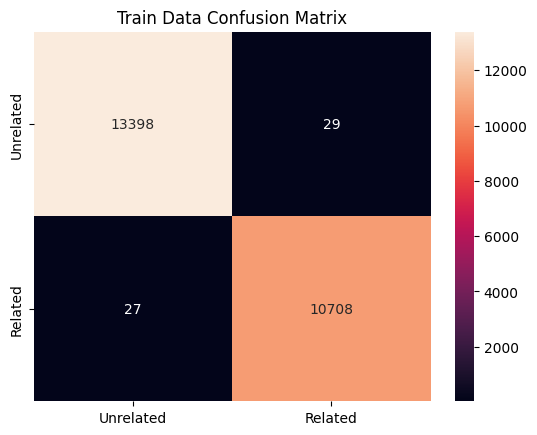

<ipython-input-40-6e6324d7828e>:30: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sbert_similarity_vectors = np.array(sbert_similarity_vectors)
<ipython-input-40-6e6324d7828e>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sbert_similarity_vectors = np.array(sbert_similarity_vectors)


 Test Data Metrics 
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      3647
           1       0.68      0.88      0.77      1351

    accuracy                           0.86      4998
   macro avg       0.82      0.86      0.83      4998
weighted avg       0.88      0.86      0.86      4998



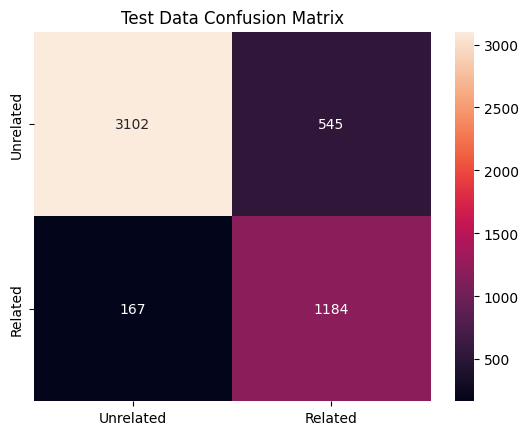

In [ ]:
# unrelated = 0, related = 1
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import util
import seaborn as sns
import matplotlib.pyplot as plt

sbert_similarity_vectors = []
for headline, body in zip(sbert_headlines, sbert_bodies):
    sbert_similarity_vectors.append(util.pytorch_cos_sim(headline, body))
sbert_similarity_vectors = np.array(sbert_similarity_vectors)

sbert_model = RandomForestClassifier().fit(sbert_similarity_vectors.reshape(-1,1), train_related_truth)

train_predictions = sbert_model.predict(sbert_similarity_vectors.reshape(-1,1))
print("Train Data Metrics ")
print(classification_report(train_related_truth, train_predictions))
print("\n")

# Plot confusion matrix for train data
train_cm = confusion_matrix(train_related_truth, train_predictions)
sns.heatmap(train_cm, annot=True, fmt="d", xticklabels=['Unrelated', 'Related'], yticklabels=['Unrelated', 'Related'])
plt.title("Train Data Confusion Matrix")
plt.show()

# test set
sbert_similarity_vectors = []
for headline, body in zip(sbert_test_headlines, sbert_test_bodies):
    sbert_similarity_vectors.append(util.pytorch_cos_sim(headline, body))
sbert_similarity_vectors = np.array(sbert_similarity_vectors)

test_predictions = sbert_model.predict(sbert_similarity_vectors.reshape(-1,1))
print(" Test Data Metrics ")
print(classification_report(test_related_truth, test_predictions))


# Plot confusion matrix for test data
test_cm = confusion_matrix(test_related_truth, test_predictions)
sns.heatmap(test_cm, annot=True, fmt="d",xticklabels=['Unrelated', 'Related'], yticklabels=['Unrelated', 'Related'])
plt.title("Test Data Confusion Matrix")
plt.show()


In [ ]:
DEEP LEarning Models

In [89]:
from random import sample
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Split the train data into train and validation sets using random sampling
indicies = list(range(len(train_headlines)))
train_indicies = sample(indicies, int(len(indicies) * 0.8))
val_indicies = set(indicies) - set(train_indicies)

# Create arrays for train and validation data
train_data_headlines = np.array(train_headlines)[train_indicies]
train_data_bodies = np.array(train_bodies)[train_indicies]
train_data_stances = np.array(train_related_truth)[train_indicies]
val_data_headlines = np.array(train_headlines)[list(val_indicies)]
val_data_bodies = np.array(train_bodies)[list(val_indicies)]
val_data_stances = np.array(train_related_truth)[list(val_indicies)]

# Create a custom dataset class
class NewsDataset(Dataset):
    def __init__(self, headlines, bodies, stances):
        self.headlines = headlines
        self.bodies = bodies
        self.stances = stances

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        x = (self.headlines[idx], self.bodies[idx])
        y = self.stances[idx]
        return x, y

# Create train, validation and test datasets
train_dataset = NewsDataset(train_data_headlines, train_data_bodies, train_data_stances)
val_dataset = NewsDataset(val_data_headlines, val_data_bodies, val_data_stances)
test_dataset = NewsDataset(test_headlines, test_bodies, test_related_truth)

In [91]:
pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

class Classifer(pl.LightningModule):
    # Initialize the model with the GRU layer, activation functions, and loss function
    def __init__(self, transformer=None, tfidf=None):
        super().__init__()
        # GRU layer parameters
        self.gru = nn.GRU(input_size=768 if transformer else 20000,
                            hidden_size=512,
                            num_layers =2,
                            dropout=0.2,
                            batch_first=True)
        # ReLU activation function
        self.relu = nn.ReLU()
        # Linear layer to output a single value
        self.linear = nn.Linear(512, 1)
        # Sigmoid activation function for binary classification
        self.sigmoid = nn.Sigmoid()
        # Binary cross-entropy loss function
        self.loss = nn.BCELoss()
        # Optional transformer and TF-IDF vectorizer
        self.transformer = transformer
        self.tfidf = tfidf       

    # Define the forward pass through the model
    def forward(self, x):
        headline, body = x
        # If using a transformer, encode the text into embeddings
        with torch.no_grad():
            if self.transformer:
                headline = self.transformer.encode(headline, convert_to_tensor=True)
                body = self.transformer.encode(body, convert_to_tensor=True)
                x = torch.cat((headline,body), dim=1)
                x = x.unsqueeze(dim=1)
            # If using TF-IDF, transform the text into dense vectors
            else:
                headline = self.tfidf.transform(headline).todense()
                body = self.tfidf.transform(body).todense()
                x = np.concatenate((headline,body), axis=1)
                x = torch.Tensor(x).to("cuda")
                x = x.unsqueeze(dim=1)
        # Pass the text embeddings/vectors through the GRU layer and activation functions
        x, _ = self.gru(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x.squeeze()

    # Define the optimizer for training the model
    def configure_optimizers(self):
        lr = 1e-3
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        return optimizer

    # Define the training step
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y = y.float()
        # Pass the input text through the model and calculate the loss
        x_hat = self.forward(x)
        loss = self.loss(x_hat, y)
        return loss

    # Define the validation step
    def validation_step(self, val_batch, batch_idx):
      x, y = val_batch
      y = y.float()
      # Pass the input text through the model and calculate the loss
      x_hat = self.forward(x)
      loss = self.loss(x_hat, y)
      y_pred = torch.round(x_hat)
      
      if batch_idx == len(self.val_dataloader()) - 1:
          # Convert the predictions and labels to numpy arrays
          y_pred_np = y_pred.cpu().detach().numpy()
          y_true_np = y.cpu().detach().numpy()

          # Calculate the confusion matrix
          cm = confusion_matrix(y_true_np, y_pred_np)

          # Plot the confusion matrix using seaborn
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

      # Calculate and log the F1 score
      f1 = f1_score(y_true_np, y_pred_np)
      self.log('val_loss', loss, on_step=False, on_epoch=True)
      self.log('val_f1', f1, on_step=False, on_epoch=True)


      # Calculate and log the F1 score
      f1 = f1_score(y_true_np, y_pred_np)
      self.log('val_loss', loss, on_step=False, on_epoch=True)
      self.log('val_f1', f1, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
      x, y = batch
      y = y.float()
      # Pass the input text through the model and calculate the predictions
      x_hat = self.forward(x)
      y_pred = torch.round(x_hat)
      # Calculate the confusion matrix and extract the true positives, false positives, true negatives, and false negatives
      tn, fp, fn, tp = confusion_matrix(y.cpu(), y_pred.cpu()).ravel()
      # Calculate accuracy, precision, recall, and F1-score
      accuracy = (tp + tn) / (tp + tn + fp + fn)
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * precision * recall / (precision + recall)
      #loss = self.loss(x_hat, y)
      # Log the metrics using PyTorch Lightning's logging system
      self.log('Test_accuracy', accuracy, on_epoch=True)
      self.log('Test_precision', precision, on_epoch=True)
      self.log('Test_recall', recall, on_epoch=True)
      self.log('Test_f1', f1, on_epoch=True)
      #self.log('Loss', loss, on_step=False, on_epoch=True)
      return {'test_accuracy': accuracy, 'test_precision': precision, 'test_recall': recall, 'test_f1': f1}


In [93]:
#traing model using BERT transformer
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)

# model
transformer = SentenceTransformer("paraphrase-MiniLM-L6-v2")
model = Classifer(transformer=transformer)


# training
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_loader)#, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                | Params
----------------------------------------------------
0 | gru         | GRU                 | 3.5 M 
1 | relu        | ReLU                | 0     
2 | linear      | Linear              | 513   
3 | sigmoid     | Sigmoid             | 0     
4 | loss        | BCELoss             | 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [94]:
#testing
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)


test_results=trainer.test(model, test_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test_accuracy       │    0.9030448717948718     │
│          Test_f1          │    0.8255767816167673     │
│      Test_precision       │    0.7954800999124173     │
│        Test_recall        │    0.8623450578528343     │
└───────────────────────────┴───────────────────────────┘

[{'Test_accuracy': 0.9030448717948718, 'Test_precision': 0.7954800999124173, 'Test_recall': 0.8623450578528343, 'Test_f1': 0.8255767816167673}]


In [ ]:
##traing model using TFIDF
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)

# model
train_tfidf_data = np.concatenate((np.unique(train_headlines), np.unique(train_bodies)))
tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2, stop_words='english', max_features=10000) 
train_tfidf = tfidf.fit(train_tfidf_data.astype('U')) 
model = Classifer(tfidf=train_tfidf)

# training
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | gru     | GRU     | 33.1 M
1 | relu    | ReLU    | 0     
2 | linear  | Linear  | 513   
3 | sigmoid | Sigmoid | 0     
4 | loss    | BCELoss | 0     
------------------------------------
33.1 M    Trainable params
0         Non-trainable params
33.1 M    T

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
#testing 
test_results_TFIDF=trainer.test(model, test_loader)
print(test_results_TFIDF)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test_accuracy       │    0.8727964743589743     │
│          Test_f1          │    0.7842276954554188     │
│      Test_precision       │    0.7222076359415648     │
│        Test_recall        │     0.862508471059125     │
└───────────────────────────┴───────────────────────────┘

[{'Test_accuracy': 0.8727964743589743, 'Test_precision': 0.7222076359415648, 'Test_recall': 0.862508471059125, 'Test_f1': 0.7842276954554188}]


In [ ]:
Agree/Disagree/Discuss Classification - GRU


In [10]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.0 MB/s eta 0:00:00


In [11]:
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

In [13]:
import random
import numpy as np
from transformers import RobertaTokenizer
from torch.utils.data import Dataset

truth_map = {0: [1.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 0.0, 1.0]}

# Training set
indicies = [i for i in range(len(train_truth)) if train_truth[i] < 3]
train_indicies = random.sample(indicies, int(len(indicies)*1))
test_indicies = set(indicies) - set(train_indicies)

train_data_headlines = [train_headlines[i] for i in train_indicies]
train_data_bodies = [train_bodies[i] for i in train_indicies]
train_data_stances = [train_truth[i] for i in train_indicies]
train_data_stance_location = {0: [], 1: [], 2: []}
for idx, i in enumerate(train_indicies):
    train_data_stance_location[train_truth[i]].append(idx)

train_data_headlines = np.array(train_data_headlines)
train_data_bodies = np.array(train_data_bodies)
train_data_stances = np.array(train_data_stances)


# Test set
indicies = [i for i in range(len(test_headlines)) if test_truth[i] < 3]
test_data_headlines = [test_headlines[i] for i in indicies]
test_data_bodies = [test_bodies[i] for i in indicies]
test_data_stances = [test_truth[i] for i in indicies] 
test_data_headlines = np.array(test_data_headlines)
test_data_bodies = np.array(test_data_bodies)
test_data_stances = np.array(test_data_stances)

class StanceDataset(Dataset):
    def __init__(self, headlines, bodies, stances, tokenizer, locations=None, loc=False):
        self.headlines = headlines
        self.bodies = bodies
        self.stances = stances
        self.tokenizer = tokenizer
        self.locations = locations
        self.loc = loc

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        if self.loc:
            r = random.random()
            if r < 0.1:
                idx = random.choice(self.locations[2])
            elif r < 0.3:
                idx = random.choice(self.locations[1])

        headline = self.headlines[idx]
        body = self.bodies[idx]
        headline_tokens = self.tokenizer.encode_plus(headline,
                                                    add_special_tokens=True,
                                                    max_length=512,
                                                    padding="max_length",
                                                    truncation=True,
                                                    return_token_type_ids=True,
                                                    return_tensors="pt")
        body_tokens = self.tokenizer.encode_plus(body,
                                                add_special_tokens=True,
                                                max_length=512,
                                                padding="max_length",
                                                truncation=True,
                                                return_token_type_ids=True,
                                                return_tensors="pt")

        headline_vals = (headline_tokens['input_ids'], headline_tokens['attention_mask'], headline_tokens["token_type_ids"])
        body_vals = (body_tokens['input_ids'], body_tokens['attention_mask'], body_tokens["token_type_ids"])
        x = (headline_vals, body_vals)
        y = self.stances[idx]
        return x, y

tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base", truncation=True, do_lower_case=True)
train_dataset = StanceDataset(train_data_headlines, train_data_bodies, train_data_stances, tokenizer, locations=train_data_stance_location, loc=True)
test_dataset = StanceDataset(test_data_headlines, test_data_bodies, test_data_stances, tokenizer)

print("Training Data Set:",len(train_dataset))
print("Test Data Set",len(test_dataset))


Training Data Set: 10735
Test Data Set 1351


In [32]:
# used pytorch lightning to make the model neater, code layout from here: https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#minimal-example
class SentimentClassifer(pl.LightningModule):
    def __init__(self, transformer, train_dataset=None, learning_rate=1e-2):
        super().__init__()
        self.gru = nn.GRU(input_size=1536,
                            hidden_size=512,
                            num_layers=2,
                            dropout=0.2,
                            batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(512, 3)
        self.softmax = nn.Softmax(dim=2)
        self.loss = nn.CrossEntropyLoss() # change weights
        self.transformer = transformer
        self.learning_rate = learning_rate 
        self.train_dataset = train_dataset

    def forward(self, x):
        headline_vals, body_vals = x
        with torch.no_grad():
            headline_roberta = self.transformer(input_ids=headline_vals[0].squeeze(dim=1), 
                                                attention_mask=headline_vals[1].squeeze(dim=1), 
                                                token_type_ids=headline_vals[2].squeeze(dim=1))
            headline_roberta = headline_roberta[0][:,0]
            body_roberta = self.transformer(input_ids=body_vals[0].squeeze(dim=1), 
                                            attention_mask=body_vals[1].squeeze(dim=1), 
                                            token_type_ids=body_vals[2].squeeze(dim=1))
            body_roberta = body_roberta[0][:,0]
            x = torch.cat((headline_roberta,body_roberta), dim=1)
            headline_roberta = body_roberta = None
            x = x.unsqueeze(dim=1)

        x, _ = self.gru(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x.squeeze()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #self.log("lr",self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=128, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x_hat = self.forward(x)
        loss = self.loss(x_hat, y)
        #self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        with torch.no_grad():
            x_hat = self.forward(x)
            loss = self.loss(x_hat, y)
            _, preds = torch.max(x_hat, 1)
            return {'val_loss': loss, 'val_preds': preds, 'val_targets': y}

    def on_validation_epoch_end(self, outputs):
        val_preds = torch.cat([x['val_preds'] for x in outputs])
        val_targets = torch.cat([x['val_targets'] for x in outputs])
        val_acc = torch.sum(val_preds == val_targets) / len(val_targets)
        print(f'Validation Accuracy: {val_acc:.4f}')
        cm = confusion_matrix(val_targets.cpu().numpy(), val_preds.cpu().numpy())
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="YlGnBu", cbar=False)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title('Confusion Matrix')
        plt.show()

    def test_step(self, batch, idx):
        x, y = batch
        with torch.no_grad():
            x_hat = self.forward(x)
            loss = self.loss(x_hat, y)

        y_pred = x_hat.argmax(dim=1)
        cm = confusion_matrix(y.cpu().numpy(), y_pred.cpu().numpy())

        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        accuracy = torch.sum(y_pred == y) / len(y)
        #self.log('test_acc', accuracy)
        return loss

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaModel
import pytorch_lightning as pl
from sklearn.metrics import classification_report
from google.colab import drive

#from my_module import SentimentClassifer, train_dataset, val_dataset, test_dataset

# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)
#val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)

# model
transformer = RobertaModel.from_pretrained("distilroberta-base")
add_model = SentimentClassifer(transformer, train_dataset)

# training
trainer = pl.Trainer(max_epochs=2)

trainer.fit(add_model, train_loader)#, val_loader)
trainer.test(add_model, test_loader)


In [82]:
import os

# mount Google Drive
drive.mount("/content/Mount", force_remount=True)

# define the file path for the saved model
save_path = '/content/Mount'


Mounted at /content/Mount


In [83]:
model_name = 'classifier.pt'
path=f'/content/Mount/My Drive/{model_name}'
torch.save(add_model.state_dict(),path)

In [34]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaModel
import pytorch_lightning as pl
from sklearn.metrics import classification_report
from google.colab import drive
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, pin_memory=True, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)

transformer = RobertaModel.from_pretrained("distilroberta-base")
add_model = SentimentClassifer(transformer)
add_model.to("cuda")

optimizer = AdamW(add_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(epochs):
    add_model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = ((inputs[0][0].to("cuda"), inputs[0][1].to("cuda"), inputs[0][2].to("cuda")), (inputs[1][0].to("cuda"), inputs[1][1].to("cuda"), inputs[1][2].to("cuda")))
        outputs = add_model(inputs)
        loss = loss_fn(outputs, labels.to("cuda"))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels.to("cuda")).sum().item()

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    add_model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = ((inputs[0][0].to("cuda"), inputs[0][1].to("cuda"), inputs[0][2].to("cuda")), (inputs[1][0].to("cuda"), inputs[1][1].to("cuda"), inputs[1][2].to("cuda")))
            outputs = add_model(inputs)
            loss = loss_fn(outputs, labels.to("cuda"))
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels.to("cuda")).sum().item()

        test_acc = 100 * test_correct / test_total
        test_loss = test_loss / len(test_loader)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}%")

print("Training completed.")


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

Epoch 1: Train Loss = 1.0227, Train Acc = 54.71%, Test Loss = 0.8947, Test Acc = 67.86%
Epoch 2: Train Loss = 0.9919, Train Acc = 55.77%, Test Loss = 0.8871, Test Acc = 67.86%
Epoch 3: Train Loss = 0.9805, Train Acc = 56.96%, Test Loss = 0.8849, Test Acc = 67.86%
Epoch 4: Train Loss = 0.9793, Train Acc = 56.98%, Test Loss = 0.8892, Test Acc = 67.86%
Epoch 5: Train Loss = 0.9780, Train Acc = 56.64%, Test Loss = 0.8936, Test Acc = 67.86%
Epoch 6: Train Loss = 0.9581, Train Acc = 57.34%, Test Loss = 0.8945, Test Acc = 67.71%
Epoch 7: Train Loss = 0.9366, Train Acc = 60.88%, Test Loss = 0.9012, Test Acc = 65.55%
Epoch 8: Train Loss = 0.9258, Train Acc = 62.63%, Test Loss = 0.8839, Test Acc = 67.04%
Epoch 9: Train Loss = 0.9181, Train Acc = 62.81%, Test Loss = 0.8821, Test Acc = 67.04%
Epoch 10: Train Loss = 0.9161, Train Acc = 62.88%, Test Loss = 0.8757, Test Acc = 67.78%
Training completed.


In [35]:
from sklearn.metrics import precision_recall_fscore_support

add_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = ((inputs[0][0].to("cuda"), inputs[0][1].to("cuda"), inputs[0][2].to("cuda")), (inputs[1][0].to("cuda"), inputs[1][1].to("cuda"), inputs[1][2].to("cuda")))
        outputs = add_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(predicted.cpu().numpy().tolist())

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

report = classification_report(y_true, y_pred)
print(report)



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       349
           1       0.28      0.49      0.35        83
           2       0.73      0.95      0.83       912

    accuracy                           0.68      1344
   macro avg       0.33      0.48      0.39      1344
weighted avg       0.51      0.68      0.58      1344



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

<Axes: >

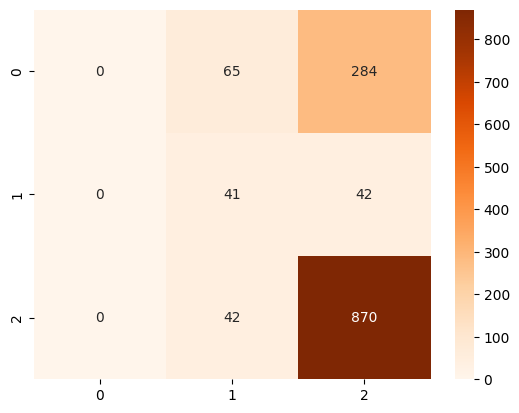

In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges')



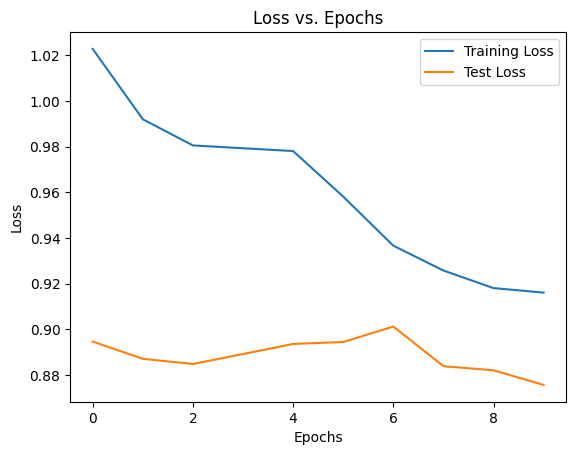

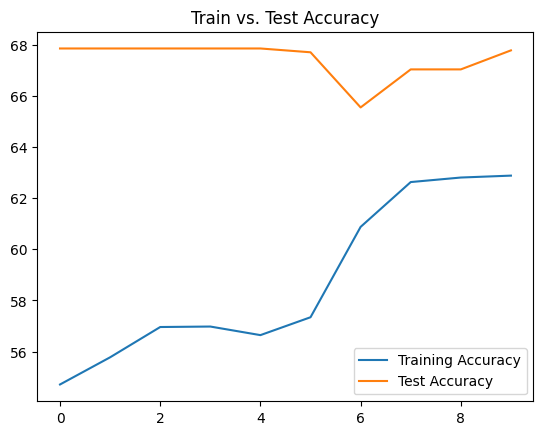

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Training Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.title("Train vs. Test Accuracy")
plt.legend()
plt.show()

In [ ]:
END to END RUN Through